In [1]:
import os
os.chdir(f'{os.environ["MT_ROOT"]}/src/') 

In [2]:

from jobs.specs.__dev import aetarn_smth_dev as opts
from models.ae_tarn import AETimeAlignedResNet
from pipeline.smth.databunch import SmthDataBunch
from models.engine import _prepare_batch
import constants as ct

import dataclasses as dc
import torch as th
import matplotlib.pyplot as plt
import numpy as np
from glob import glob



In [3]:
def pic_show(_video):
    num = len(_video)
    fig = plt.figure(figsize=(16, 32), dpi=80)
    for i in range(1,num+1):
        sub = fig.add_subplot(1,num,i)
        sub.set_title(str(i))
        sub.axis('off')
        sub.imshow(_video[i-1])
    plt.show()

def un_normalize(_x):
    return _x * 255

def un_standardize(_x):
    means = th.tensor(ct.IMAGE_NET_MEANS).reshape((1, 3, 1, 1))
    stds = th.tensor(ct.IMAGE_NET_STDS).reshape((1, 3, 1, 1))
    
    return _x * stds + means

In [13]:
opts.trainer_opts.optimizer_opts.lr = 0.005
opts.valid_dl_opts.batch_size = 1
opts.dev_dl_opts.batch_size = 1
opts.train_dl_opts.batch_size = 1
opts.trainer_opts.criterion_opts.mse_factor = 1.0
opts.trainer_opts.criterion_opts.ce_factor = 1.0
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

model = AETimeAlignedResNet(**dc.asdict(opts.model_opts)).to(device)
best_model = glob((ct.SMTH_RUN_DIR / '__dev' / 'aetarn_smth_dev@1.0_1.0' / 'best_model_*.pth').as_posix()).pop()
model.load_state_dict(th.load(best_model, map_location=device))
bunch = SmthDataBunch(opts.db_opts, 
                      opts.train_ds_opts, opts.dev_ds_opts, opts.valid_ds_opts, 
                      opts.train_dl_opts, opts.dev_dl_opts, opts.valid_dl_opts)
optimizer = opts.trainer_opts.optimizer(model.parameters(), **dc.asdict(opts.trainer_opts.optimizer_opts))
loss_fn = opts.trainer_opts.criterion(**dc.asdict(opts.trainer_opts.criterion_opts)).to(device)
lr_scheduler = th.optim.lr_scheduler.StepLR(optimizer, 100, 0.5)

In [22]:
dev_loader = iter(bunch.dev_loader)
batch = next(dev_loader)
batch = next(dev_loader)
video, label = bunch.dev_set[1]
x, y = _prepare_batch(batch, device, False)

In [23]:
video, label

(Video 5791 (4x3x224x224), (14 Uncovering something))

In [24]:
# for _ in range(100):
#     model.train()
#     optimizer.zero_grad()
#     _pred, _latent, _recon = model(x, inference=False)
#     mse, ce = loss_fn(_recon, _pred.reshape(1, 30), x, y)
#     (mse + ce).backward()
#     print(f'{_}={mse:.4f} | {ce:.4f}')
#     optimizer.step()
#     lr_scheduler.step()
model.eval()
_pred, _latent, _recon = model(x, inference=False)

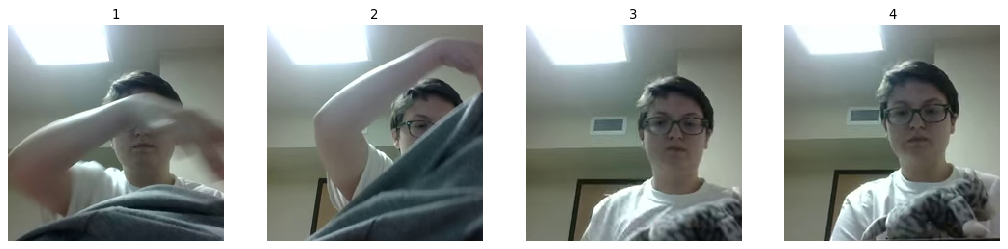

In [25]:
_in = video.data.astype(np.int).swapaxes(1,2).swapaxes(2,3)
pic_show(_in)

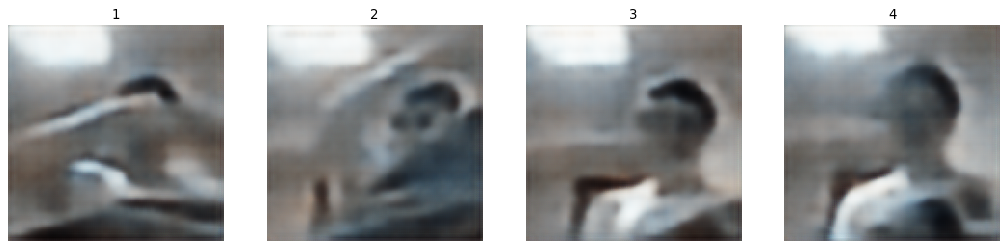

In [26]:
_rec = un_normalize(un_standardize(_recon.detach().cpu()))
_rec = _rec.numpy().reshape(4, 3, 224, 224).astype(np.int).swapaxes(1,2).swapaxes(2,3)
pic_show(_rec)

In [10]:
_recon.min(), _recon.max(), _rec.min(), _rec.max()

(tensor(-1.7929, grad_fn=<MinBackward1>),
 tensor(1.4080, grad_fn=<MaxBackward1>),
 18,
 196)

In [11]:
un_standardize(_recon.detach().cpu()).min(), un_standardize(_recon.detach().cpu()).max()

(tensor(0.0744), tensor(0.7708))